In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


## Files:

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

## Data description:

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

## Data preprocessing

In [2]:
sample_df = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv")
items = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
train_df = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test_df = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")
item_categories = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")

In [3]:
sample = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [4]:
display(shops.head())
display(item_categories.head())
display(items.head())
display(train_df.head())
display(test_df.head())

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


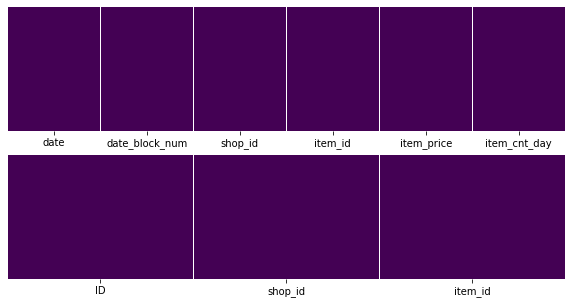

In [5]:
plt.subplots(figsize=(10, 5))
plt.subplot(2, 1, 1)
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.subplot(2, 1, 2)
sns.heatmap(test_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

There are no nan-values in the train_df and test_df

Attach items to train_df by the item_id column for the item_category_id feature.

In [6]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [7]:
train_df = train_df.merge(items, on = 'item_id', how = 'left')

In [8]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56


## Feature engeineering (add datetime features)

In [9]:
train_df.date = train_df.date.apply(lambda date_str: datetime.strptime(date_str, '%d.%m.%Y'))

train_df['month'] = train_df.date.apply(lambda date: date.month) 
train_df['year'] = train_df.date.apply(lambda date: date.year)

## Features removing

In [10]:
train_df.drop(['item_name', 'date', 'item_price', 'item_category_id'], axis = 'columns', inplace = True)

## Grouping and aggregating

In [11]:
train_df = train_df.groupby(by = ["date_block_num", "shop_id", "item_id", "month", "year"]).sum().reset_index()

In [12]:
train_df.sample(5)

,date_block_num,shop_id,item_id,month,year,item_cnt_day
1464150,29,28,20951,6,2015,1.0
1147830,21,57,12333,10,2014,1.0
1119912,21,24,18592,10,2014,1.0
196442,3,18,1196,4,2013,1.0
27770,0,27,2493,1,2013,2.0


## Preprocessing of the test_df

In [13]:
display(test_df.head())
print(test_df.shape)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


(214200, 3)


In [14]:
test_df['month'] = 11 # by the task condition
test_df['year'] = 2015 # by the task condition
test_df['date_block_num'] = 34 # by the task condition

difference = list(set(train_df.columns) - set(test_df.columns))
difference.remove('item_cnt_day')

## Machine Learning

In [15]:
Y = train_df['item_cnt_day']
train_df.drop('item_cnt_day', axis = 1, inplace = True)
X = train_df
X.drop(difference, axis = 1, inplace = True)

ID = test_df['ID']
test_df.drop(['ID'], axis = 1, inplace = True)

In [16]:
def poly(df):
    poly = PolynomialFeatures(2, interaction_only=True)
    x = poly.fit(df)
    df = pd.DataFrame(x.transform(df), columns=x.get_feature_names(df.columns))
    return df

X = poly(X)
test_df = poly(test_df)

In [17]:
test_df.head()

,1,shop_id,item_id,month,year,date_block_num,shop_id item_id,shop_id month,shop_id year,shop_id date_block_num,item_id month,item_id year,item_id date_block_num,month year,month date_block_num,year date_block_num
0,1.0,5.0,5037.0,11.0,2015.0,34.0,25185.0,55.0,10075.0,170.0,55407.0,10149555.0,171258.0,22165.0,374.0,68510.0
1,1.0,5.0,5320.0,11.0,2015.0,34.0,26600.0,55.0,10075.0,170.0,58520.0,10719800.0,180880.0,22165.0,374.0,68510.0
2,1.0,5.0,5233.0,11.0,2015.0,34.0,26165.0,55.0,10075.0,170.0,57563.0,10544495.0,177922.0,22165.0,374.0,68510.0
3,1.0,5.0,5232.0,11.0,2015.0,34.0,26160.0,55.0,10075.0,170.0,57552.0,10542480.0,177888.0,22165.0,374.0,68510.0
4,1.0,5.0,5268.0,11.0,2015.0,34.0,26340.0,55.0,10075.0,170.0,57948.0,10615020.0,179112.0,22165.0,374.0,68510.0


In [18]:
X = np.expand_dims(X, 1) # for mlp we need to add new axis
test_df = np.expand_dims(test_df, 1)

In [19]:
# creating a neural network architecture
my_model = Sequential()
my_model.add(LSTM(64, input_shape=(X.shape[1:])))
my_model.add(Dense(1))
my_model.add(Dropout(0.4))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________


In [20]:
my_model.fit(X,Y,batch_size = 4096,epochs = 8)

Epoch 1/8
393/393 [==============================] - 6s 16ms/step - loss: 77.2505 - mean_squared_error: 77.2505
Epoch 2/8
393/393 [==============================] - 6s 16ms/step - loss: 76.8890 - mean_squared_error: 76.8890
Epoch 3/8
393/393 [==============================] - 6s 16ms/step - loss: 76.8912 - mean_squared_error: 76.8912
Epoch 4/8
393/393 [==============================] - 6s 16ms/step - loss: 76.8827 - mean_squared_error: 76.8827
Epoch 5/8
393/393 [==============================] - 6s 16ms/step - loss: 76.8651 - mean_squared_error: 76.8651
Epoch 6/8
393/393 [==============================] - 6s 16ms/step - loss: 76.8709 - mean_squared_error: 76.8709
Epoch 7/8
393/393 [==============================] - 6s 16ms/step - loss: 76.8926 - mean_squared_error: 76.8926
Epoch 8/8
393/393 [==============================] - 6s 16ms/step - loss: 76.8766 - mean_squared_error: 76.8766


## Output

In [21]:
# creating submission file 
predictions = my_model.predict(test_df)
# we will keep every value between 0 and 20
predictions = predictions.clip(0,20)

In [22]:
output = pd.DataFrame({'ID': ID, 'item_cnt_month': np.round(predictions.ravel(), 1)})
output.to_csv('my_submission.csv', index=False)